# Text Mining Project 2

In [ ]:
%pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.6 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=621df13f17ab7877f0c3083f59c06af5a268e1440f3768c299bfcfa747ffd6a2
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c82c03da1e77740a232bea422f1844fc2bd2846c35a8bf4645f42ec400eee23c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from textblob import TextBlob
from transformers import BartTokenizer, BartForConditionalGeneration

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
reviews_df = pd.read_csv('./Restaurant_Reviews.csv')

good_reviews = reviews_df[reviews_df['Liked'] == 1]['Review']
bad_reviews = reviews_df[reviews_df['Liked'] == 0]['Review']

print(f"Number of total reviews:", len(reviews_df))
print(f"Number of good reviews:", len(good_reviews))
print(f"Number of bad reviews:", len(bad_reviews))

Number of total reviews: 1000
Number of good reviews: 500
Number of bad reviews: 500


In [ ]:
def calculate_average_length(reviews, category):
    word_lengths = reviews.apply(lambda x: [len(word) for word in x.split()])
    flattened_lengths = [length for sublist in word_lengths for length in sublist]
    average_word_length = sum(flattened_lengths) / len(flattened_lengths)

    average_review_length = reviews.apply(lambda x: len(x)).mean()

    word_counts = reviews.apply(lambda x: len(x.split()))
    average_word_count = word_counts.mean()

    print(f'Average number of words in {category} reviews: {average_word_count:.2f} words')
    print(f'Average review length in {category} reviews: {average_review_length:.2f} characters')
    print(f'Average word length in {category} reviews: {average_word_length:.2f} characters')

calculate_average_length(good_reviews, 'good')

print()

calculate_average_length(bad_reviews, 'bad')

Average number of words in good reviews: 10.29 words
Average review length in good reviews: 55.88 characters
Average word length in good reviews: 4.53 characters

Average number of words in bad reviews: 11.50 words
Average review length in bad reviews: 60.75 characters
Average word length in bad reviews: 4.37 characters


In [ ]:
stop_words = set(stopwords.words('english'))

def get_sentiment_score(reviews, category):
    tokens = []

    for review in reviews:
        tokens.extend(review.split())

    filtered_tokens = [token for token in tokens if token not in stop_words]
    sentiment_scores = []

    for token in filtered_tokens:
        blob = TextBlob(token)
        sentiment_scores.append(blob.sentiment.polarity)

    avg_sentiment_score = sum(sentiment_scores) / len(sentiment_scores)

    print('Average sentiment score for ' + category + ' reviews:', avg_sentiment_score)

get_sentiment_score(good_reviews, 'good')
get_sentiment_score(bad_reviews, 'bad')

Average sentiment score for good reviews: 0.1053671174360427
Average sentiment score for bad reviews: -0.012769061550041368


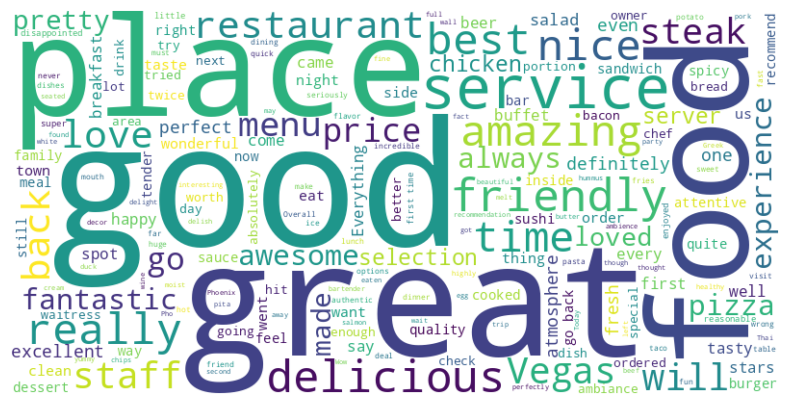

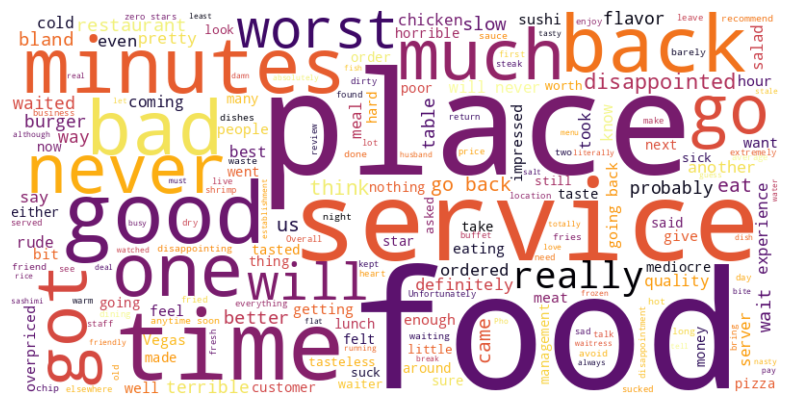

In [ ]:
TOP_WORDS_NUMBER = 30

def generate_word_cloud(text, category):
    colormap = 'viridis' if category == 'Good' else 'inferno'
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    # plt.title(f"{category} Reviews Word Cloud")
    plt.show()

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    return ' '.join(filtered_words)

clickbait_text = ' '.join(good_reviews)

generate_word_cloud(clickbait_text, 'Good')

non_clickbait_text = ' '.join(bad_reviews)

generate_word_cloud(non_clickbait_text, 'Bad')

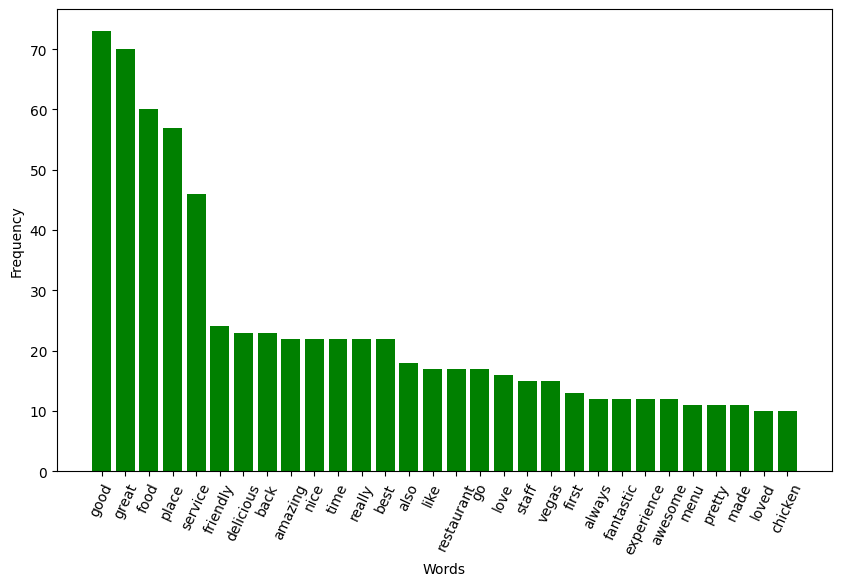

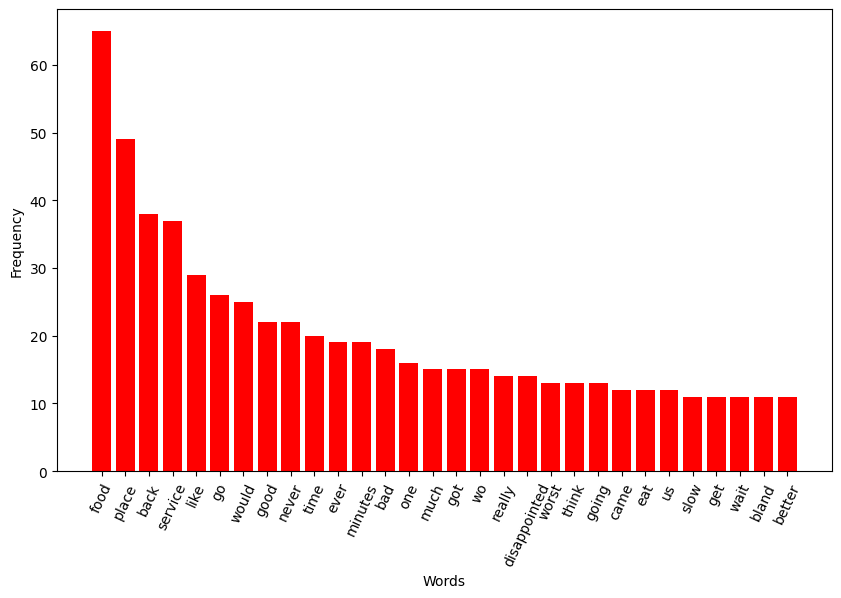

In [ ]:
def get_most_common_words(reviews, category, number_of_common_words):
  reviews_text = ' '.join(reviews)
  tokens = word_tokenize(reviews_text)
  filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
  freq_dist = FreqDist(filtered_tokens)
  color = 'green' if category == 'Good' else 'red'

  plt.figure(figsize=(10, 6))
  plt.bar(*zip(*freq_dist.most_common(number_of_common_words)), color=color)
  plt.xticks(rotation=65)
  # plt.title(f"Top {number_of_common_words} Common Words in {category} Reviews (excluding stop words)")
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.show()

get_most_common_words(good_reviews, 'Good', 30)
get_most_common_words(bad_reviews,'Bad', 30)

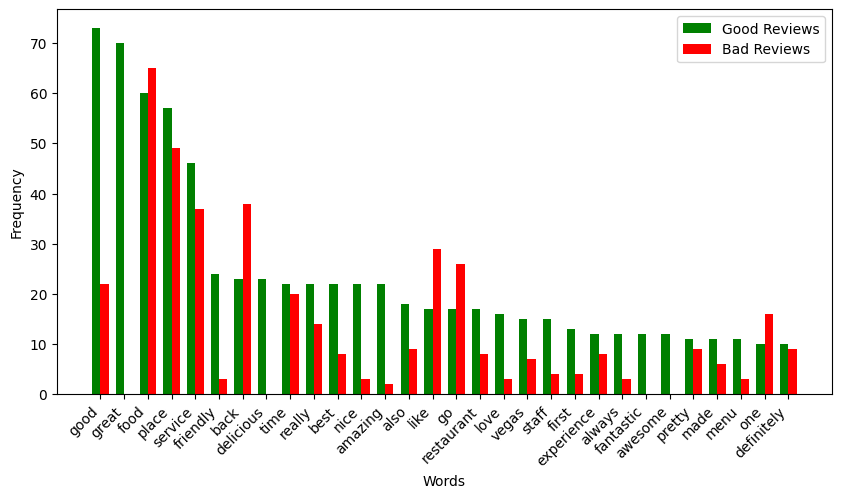

In [ ]:
def plot_most_used_words(good_reviews, bad_reviews):
    good_text = ' '.join(good_reviews)
    bad_text = ' '.join(bad_reviews)

    good_text = remove_stopwords(good_text)
    bad_text = remove_stopwords(bad_text)

    good_word_counts = Counter(good_text.split())
    bad_word_counts = Counter(bad_text.split())

    common_words = set(good_word_counts).union(bad_word_counts)
    common_words = sorted(common_words, key=lambda x: (good_word_counts[x], bad_word_counts[x]), reverse=True)[:TOP_WORDS_NUMBER]

    good_counts = [good_word_counts[word] for word in common_words]
    bad_counts = [bad_word_counts[word] for word in common_words]

    bar_width = 0.35
    index = range(len(common_words))

    plt.figure(figsize=(10, 5))
    plt.bar(index, good_counts, bar_width, label='Good Reviews', color='green')
    plt.bar([i + bar_width for i in index], bad_counts, bar_width, label='Bad Reviews', color='red')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    # plt.title(f"Top {TOP_WORDS_NUMBER} Common Words in Reviews (excluding stop words)")
    plt.xticks([i + bar_width / 2 for i in index], common_words, rotation=45, ha='right')
    plt.legend()
    plt.show()

plot_most_used_words(good_reviews, bad_reviews)

In [ ]:
def do_latent_dirichlet_allocation(reviews, category):
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(reviews)
    num_topics = 5
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=10)

    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()

    print(f"Top {num_topics} topics for {category} reviews:")

    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]

        print(f'Topic {topic_idx + 1}: {", ".join(top_words)}')

do_latent_dirichlet_allocation(good_reviews, 'good')

print()

do_latent_dirichlet_allocation(bad_reviews, 'bad')

Top 5 topics for good reviews:
Topic 1: place, good, just, like, love, time, spot, best, nice, better
Topic 2: food, great, service, good, delicious, place, selection, awesome, atmosphere, amazing
Topic 3: great, friendly, staff, restaurant, amazing, service, family, pizza, come, menu
Topic 4: nice, best, time, vegas, excellent, steak, did, buffet, good, delicious
Topic 5: good, really, experience, place, chicken, definitely, tasty, ll, went, salad

Top 5 topics for bad reviews:
Topic 1: like, service, waited, came, got, times, minutes, rude, just, waiter
Topic 2: food, don, place, eating, probably, didn, think, know, flavor, sucked
Topic 3: food, good, ve, bad, place, bland, worst, like, better, service
Topic 4: place, service, food, going, slow, way, wasn, won, stars, overpriced
Topic 5: food, did, time, place, really, won, minutes, pretty, say, money


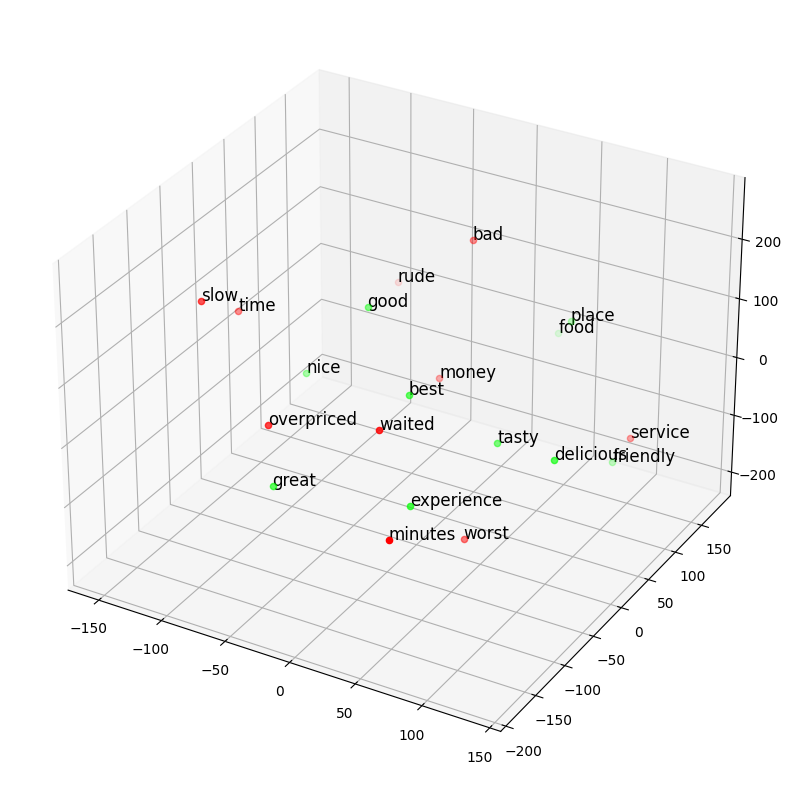

In [ ]:
all_reviews = reviews_df['Review'].tolist()
tokenized_reviews = [word_tokenize(review.lower()) for review in all_reviews]
filtered_reviews = [[word for word in tokens if word.isalpha() and word not in stop_words] for tokens in tokenized_reviews]
model = Word2Vec(sentences=filtered_reviews, vector_size=100, window=5, min_count=1, workers=4)

def plot_word_embeddings_3d(model, good_words, bad_words):
    all_words = good_words + bad_words
    word_vectors = np.array([model.wv[word] for word in all_words])
    tsne_model = TSNE(n_components=3, random_state=42, perplexity=5)
    embeddings_3d = tsne_model.fit_transform(word_vectors)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    for j, word in enumerate(all_words):
        color = (0, 1, 0) if word in good_words else (1, 0, 0)
        opacity = max(0.1, 1.0 - (embeddings_3d[j, 1] - min(embeddings_3d[:, 1])) / (max(embeddings_3d[:, 1]) - min(embeddings_3d[:, 1])))

        ax.scatter(embeddings_3d[j, 0], embeddings_3d[j, 1], embeddings_3d[j, 2], marker='o', color=color + (opacity,))
        ax.text(embeddings_3d[j, 0], embeddings_3d[j, 1], embeddings_3d[j, 2], word, fontsize=12)

    # ax.set_title("Words Visualization (t-SNE)")

    plt.show()

good_words = ['good', 'nice', 'best', 'great', 'place', 'delicious', 'tasty', 'food', 'friendly', 'experience']
bad_words = ['bad', 'worst', 'rude', 'waited', 'time', 'minutes', 'slow', 'service', 'money', 'overpriced']

plot_word_embeddings_3d(model, good_words, bad_words)

In [ ]:
def get_reviews_summary(reviews, category, number_of_sentences):
    reviews_text = ' '.join(reviews)
    parser = PlaintextParser.from_string(reviews_text, Tokenizer('english'))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count=3)

    print(f"{category} reviews summarized in {number_of_sentences} sentences:")

    for sentence in summary:
        print(sentence)

get_reviews_summary(good_reviews, 'Good', 3)

print()

get_reviews_summary(bad_reviews, 'Bad', 3)

Good reviews summarized in 3 sentences:
They will customize your order any way you'd like, my usual is Eggplant with Green Bean stir fry, love it!
The food is delicious and just spicy enough, so be sure to ask for spicier if you prefer it that way.
They also now serve Indian naan bread with hummus and some spicy pine nut sauce that was out of this world.

Bad reviews summarized in 3 sentences:
He was extremely rude and really, there are so many other restaurants I would love to dine at during a weekend in Vegas.
I also decided not to send it back because our waitress looked like she was on the verge of having a heart attack.
Bad day or not, I have a very low tolerance for rude customer service people, it is your job to be nice and polite, wash dishes otherwise!!


In [ ]:
def summarize_reviews(reviews, category, max_input_length=1024, max_output_length=150):
    model_name = "facebook/bart-large-cnn"
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)
    concatenated_reviews = " ".join(reviews.tolist())
    input_ids = tokenizer.encode(concatenated_reviews, return_tensors="pt", max_length=max_input_length, truncation=True)
    summary_ids = model.generate(input_ids, max_length=max_output_length, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"\n{category} reviews summary:")
    print(summary)

summarize_reviews(good_reviews, 'Good')

print()

summarize_reviews(bad_reviews, 'Bad')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]


Good reviews summary:
Dos Gringos is one of the best breakfast bars in Vegas. The food and service is outstanding. The cocktails are all handmade and delicious. This is a really fantastic Thai restaurant which is definitely worth a visit. This place receives stars for their APPETIZERS!!!


Bad reviews summary:
Crust is not good. Not tasty and the texture was just nasty. The Burrittos Blah! - They never brought a salad we asked for. Took an hour to get our food only 4 tables in restaurant my food was Luke warm, Our sever was running around like he was totally overwhelmed.


In [ ]:
import pandas
import wordcloud
import matplotlib
import nltk
import sklearn
import gensim
import numpy
import sumy
import textblob
import transformers

print('Package versions:')
print('pandas - ', pandas.__version__)
print('wordcloud - ', wordcloud.__version__)
print('matplotlib - ', matplotlib.__version__)
print('nltk - ', nltk.__version__)
print('sklearn - ', sklearn.__version__)
print('gensim - ', gensim.__version__)
print('numpy - ', numpy.__version__)
print('sumy - ', sumy.__version__)
print('textblob - ', textblob.__version__)
print('transformers - ', transformers.__version__)

Package versions:
pandas -  1.5.3
wordcloud -  1.9.3
matplotlib -  3.7.1
nltk -  3.8.1
sklearn -  1.2.2
gensim -  4.3.2
numpy -  1.23.5
sumy -  0.11.0
textblob -  0.17.1
transformers -  4.35.2
